In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('boston2014.csv')
print(df.shape, '\n')
print(df.dtypes)
df.head()

(31984, 21) 

10k           object
name          object
division       int64
25k           object
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k           object
overall        int64
pace         float64
state         object
30k           object
5k            object
half          object
20k           object
country       object
city          object
40k           object
dtype: object


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
#convert splits from object to numerics
splits = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df[splits] = df[splits].apply(pd.to_numeric, errors='coerce', axis=1)
df.dtypes

10k          float64
name          object
division       int64
25k          float64
gender        object
age            int64
official     float64
bib           object
genderdiv      int64
ctz           object
35k          float64
overall        int64
pace         float64
state         object
30k          float64
5k           float64
half         float64
20k          float64
country       object
city          object
40k          float64
dtype: object

In [4]:
#make a list of categorical features except for gender
categoricals = ['name', 'bib', 'ctz', 'state', 'country', 'city']

#clustering doesn't work with categorical features so we will drop them
df = df.drop(categoricals, 1)

In [5]:
#convert gender into a binary format for analysis
df['gender'] = np.where(df['gender'] == 'M', 0, 1).astype('int64')

#drop NaN values
df = df.dropna()
df.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,0,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,1,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,0,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,1,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,0,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


In [6]:
#create feature set and target set
X = df.drop('gender', 1)
y = df.gender

In [7]:
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#make sure the number of rows divides evenly into four samples
rows = X.shape[0] - X.shape[0] % 4
X = X.iloc[:rows, :]

#normalize the data.
X_norm = normalize(X)

#PCA with two components for plotting with 3 PCA components which was already calculated
pca = PCA(3)
X_pca = pca.fit_transform(X_norm)

print(X.shape)

(31648, 14)


In [8]:
from sklearn.model_selection import train_test_split

#train test split our group into equal quadrants
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_norm, X_pca, test_size=0.5)

X1, X2, X_pca1, X_pca2 = train_test_split(X_half1, X_pcahalf1, test_size=0.5,)
    
X3, X4, X_pca3, X_pca4 = train_test_split(X_half2, X_pcahalf2, test_size=0.5)

In [11]:
from sklearn import metrics
import matplotlib.cm as cm

'''Pass a list of tuples and a counter that increments each time we go through the loop. 
The tuples are the data to be used by k-means, and the PCA-derived features for graphing. 
We use k-means to fit a model to the data, then store the predicted values and the two-feature 
PCA solution in the data frame.'''

#function that plots kmeans clustering and returns the optimal number of clusters
def evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, clust_range):

    plot_clusters = pd.DataFrame()
    cluster_scores = pd.DataFrame(columns=['clusters','mean score','std'])
#compare our 4 even sections to each other and return a silhouette score
    for index, data in enumerate([
        (X1, X_pca1),
        (X2, X_pca2),
        (X3, X_pca3),
        (X4, X_pca4)]):

        plot_clusters['pca_f1' + '_sample' + str(index)] = data[1][:, 0]
        plot_clusters['pca_f2' + '_sample' + str(index)] = data[1][:, 1]

        for nclust in range(2, clust_range):
            km = KMeans(n_clusters=nclust, random_state=42)
            km.fit(data[0])
            labels = km.labels_
            cluster_pred = km.predict(data[0])
            plot_clusters['clust' + str(nclust) + '_sample' + str(index)] = cluster_pred
            plot_clusters['sil_score_' + 'clust'+ str(nclust) + '_sample' + str(index)] = \
                                metrics.silhouette_score(data[0], labels, metric='euclidean')
#plot the kmeans scores
    for nclust in range(2, clust_range):

        colors = cm.rainbow(np.linspace(0, 1, nclust))
        f, plotgrid = plt.subplots(2, 2)
        sil_scores = []

        for i in range(4):

            current_group = (f'clust{nclust}_sample{i}')

            x_plot = plot_clusters[f'pca_f1_sample{i}']
            y_plot = plot_clusters[f'pca_f2_sample{i}']

            c = plot_clusters[current_group]

            rows = int(np.floor(i / 2))
                # 0,0,1,1
            cols = i % 2
                # 0,1,0,1

            plotgrid[rows, cols].scatter(x_plot, y_plot, color = colors[c], alpha = 0.4)
            plotgrid[rows, cols].set_title(f'sample {i}')
            plotgrid[rows, cols].set_xlim([-.3, .3])
            plotgrid[rows, cols].set_ylim([-.3, .3])

            sil_score = plot_clusters['sil_score_' + str(current_group)].mean()
            sil_scores.append(sil_score)

#group the silhouette scores and print the means and standard deviations
        group_sil_scores_mean = np.mean(sil_scores)
        group_sil_scores_std = np.std(sil_scores)
        cluster_scores = cluster_scores.append({'clusters':int(nclust), 'mean score': group_sil_scores_mean, 'std': group_sil_scores_std}, ignore_index=True)
        print('scores:')
        print(cluster_scores)

        plt.suptitle(f'{nclust} Clusters', fontsize=20)
        plt.tight_layout()
        plt.show()
        print('\n')
    
    print('sorted cluster scores:')
    sorted_scores = cluster_scores.sort_values(by = ['mean score'], ascending = False)
    print(sorted_scores)

    best_cluster_num = int(sorted_scores['clusters'].iloc[0])
    print('best cluster num:')
    print(best_cluster_num)
    
    return best_cluster_num

scores:
   clusters  mean score      std
0       2.0    0.453278  0.00307


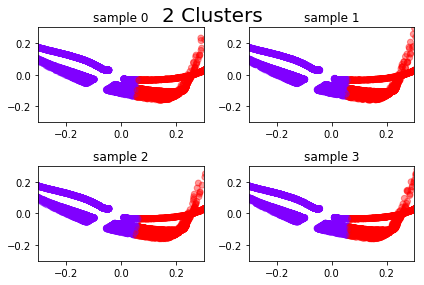



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036


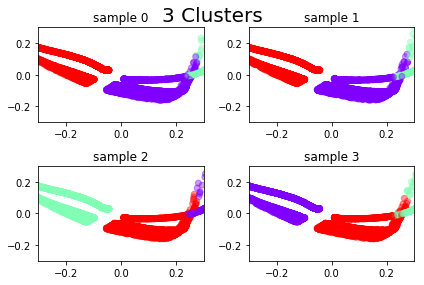



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444


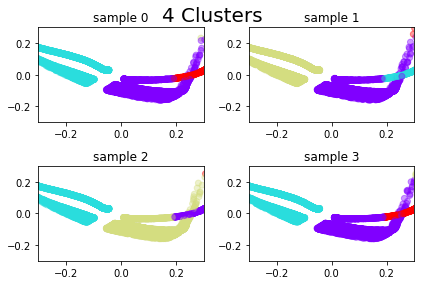



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819


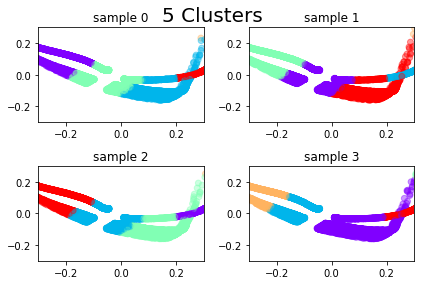



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902


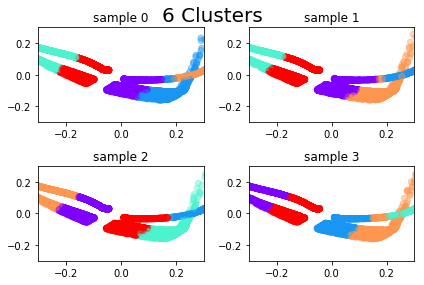



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902
5       7.0    0.527432  0.005328


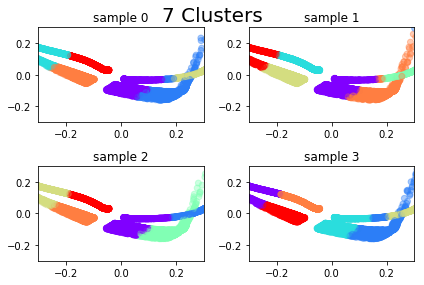



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902
5       7.0    0.527432  0.005328
6       8.0    0.532941  0.004336


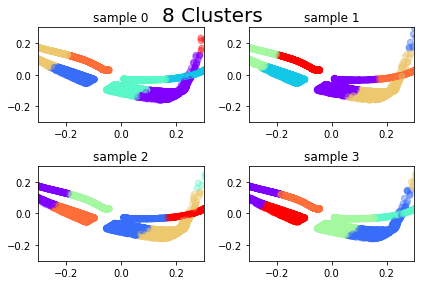



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902
5       7.0    0.527432  0.005328
6       8.0    0.532941  0.004336
7       9.0    0.557743  0.003120


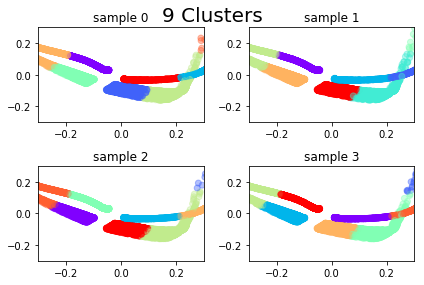



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902
5       7.0    0.527432  0.005328
6       8.0    0.532941  0.004336
7       9.0    0.557743  0.003120
8      10.0    0.553048  0.005537


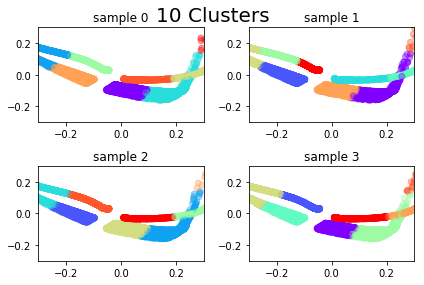



scores:
   clusters  mean score       std
0       2.0    0.453278  0.003070
1       3.0    0.477913  0.001036
2       4.0    0.495065  0.000444
3       5.0    0.411479  0.022819
4       6.0    0.450606  0.004902
5       7.0    0.527432  0.005328
6       8.0    0.532941  0.004336
7       9.0    0.557743  0.003120
8      10.0    0.553048  0.005537
9      11.0    0.556023  0.004313


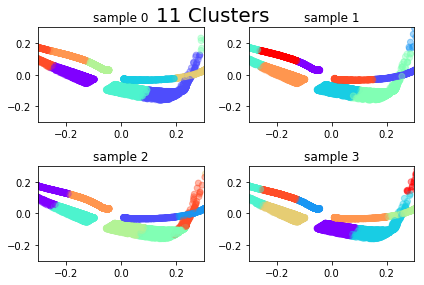



scores:
    clusters  mean score       std
0        2.0    0.453278  0.003070
1        3.0    0.477913  0.001036
2        4.0    0.495065  0.000444
3        5.0    0.411479  0.022819
4        6.0    0.450606  0.004902
5        7.0    0.527432  0.005328
6        8.0    0.532941  0.004336
7        9.0    0.557743  0.003120
8       10.0    0.553048  0.005537
9       11.0    0.556023  0.004313
10      12.0    0.546911  0.010373


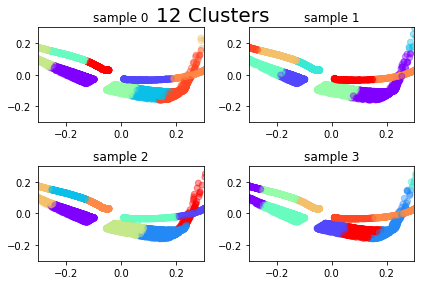



scores:
    clusters  mean score       std
0        2.0    0.453278  0.003070
1        3.0    0.477913  0.001036
2        4.0    0.495065  0.000444
3        5.0    0.411479  0.022819
4        6.0    0.450606  0.004902
5        7.0    0.527432  0.005328
6        8.0    0.532941  0.004336
7        9.0    0.557743  0.003120
8       10.0    0.553048  0.005537
9       11.0    0.556023  0.004313
10      12.0    0.546911  0.010373
11      13.0    0.548871  0.012221


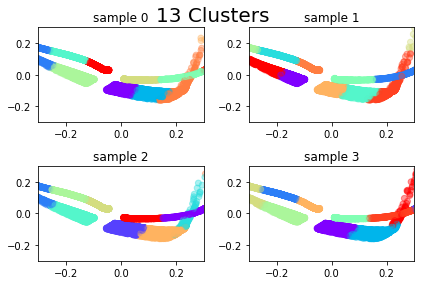



sorted cluster scores:
    clusters  mean score       std
7        9.0    0.557743  0.003120
9       11.0    0.556023  0.004313
8       10.0    0.553048  0.005537
11      13.0    0.548871  0.012221
10      12.0    0.546911  0.010373
6        8.0    0.532941  0.004336
5        7.0    0.527432  0.005328
2        4.0    0.495065  0.000444
1        3.0    0.477913  0.001036
0        2.0    0.453278  0.003070
4        6.0    0.450606  0.004902
3        5.0    0.411479  0.022819
best cluster num:
9


In [12]:
best_cluster_num = evaluate_kmeans(X1, X_pca1, X2, X_pca2, X3, X_pca3, X4, X_pca4, 14)

Using 9 clusters gave the highest mean silhouette score (0.558) and the smallest standard deviation (0.001). Not only did it perform the best out of all the iterations, it also performed the most consistently every time. Let's take a deeper look into some summary statistics for each of these 9 clusters.

In [15]:
def investigate_kmeans(X, best_cluster_num):
    best_cluster_pred = KMeans(n_clusters=best_cluster_num, random_state=42).fit_predict(X)
    X_pred = X.copy()
    X_pred['cluster_assignment'] = best_cluster_pred

    cluster_dataframes = {}
    for n_clust in range(best_cluster_num):
        cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

    for name, frame in cluster_dataframes.items():
        print(name)
        print(frame.describe())
        
    return X_pred

continuous2014_pred = investigate_kmeans(X, best_cluster_num)

0
               10k     division          25k          age     official  \
count  2482.000000  2482.000000  2482.000000  2482.000000  2482.000000   
mean     64.491475  5858.912168   174.351523    30.795729   324.334911   
std       5.894413   551.364076    17.568220     5.193997    29.187537   
min      44.900000  4867.000000   117.780000    18.000000   282.250000   
25%      60.800000  5474.250000   161.985000    27.000000   300.820000   
50%      64.070000  5786.000000   172.025000    31.000000   318.520000   
75%      68.045000  6302.750000   185.007500    35.000000   341.387500   
max      94.450000  6979.000000   281.850000    39.000000   534.220000   

          genderdiv          35k       overall         pace          30k  \
count   2482.000000  2482.000000   2482.000000  2482.000000  2482.000000   
mean   14072.620064   262.903131  28735.978243    12.378771   217.311773   
std     1756.867681    25.111135   1739.318280     1.113320    21.630013   
min    11298.000000   183.3

max      37.920000   165.030000   159.170000   284.730000                 6.0  
7
               10k     division          25k          age     official  \
count  3394.000000  3394.000000  3394.000000  3394.000000  3394.000000   
mean     44.404493  1358.872717   112.379216    43.533589   200.259688   
std       2.279764  1009.245524     4.927644     8.791334     5.763715   
min      32.120000     1.000000    82.230000    18.000000   189.920000   
25%      42.880000   624.250000   109.100000    38.000000   195.070000   
50%      44.430000   981.500000   112.570000    45.000000   200.090000   
75%      45.970000  2495.750000   115.870000    50.000000   205.227500   
max      53.730000  3350.000000   128.780000    73.000000   210.180000   

         genderdiv          35k      overall         pace          30k  \
count  3394.000000  3394.000000  3394.000000  3394.000000  3394.000000   
mean   5553.954920   162.271388  6608.261933     7.646223   136.623111   
std     985.190093     5.5078